# 1) Download required files 

In [1]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

--2021-02-17 15:11:49--  https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘inferenceutils.py’

inferenceutils.py   100%[===================>]   2.17K  --.-KB/s    in 0.002s  

2021-02-17 15:11:49 (916 KB/s) - ‘inferenceutils.py’ saved [2219/2219]



# 2) Extract the saved model

In [3]:
%%bash
unzip saved_model_frcnn_v1.zip
mv content/inference_graph/saved_model/label_map.pbtxt ./
mkdir dataset
mv content/inference_graph/saved_model/test_labels.csv ./dataset/
mkdir dataset/images
mkdir dataset/images/test
cp content/inference_graph/saved_model/test/* ./dataset/images/test

Archive:  saved_model_frcnn_v1.zip
   creating: content/inference_graph/saved_model/
   creating: content/inference_graph/saved_model/assets/
   creating: content/inference_graph/saved_model/variables/
  inflating: content/inference_graph/saved_model/variables/variables.index  
  inflating: content/inference_graph/saved_model/variables/variables.data-00000-of-00001  
   creating: content/inference_graph/saved_model/test/
  inflating: content/inference_graph/saved_model/test/Invoice_156.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_126_affine_translation.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_115_gaussianblur.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_142_horizontallyflip.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_166_horizontallyflip.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice_98_horizontallyflip.jpg  
  inflating: content/inference_graph/saved_model/test/Invoice

# 3) Recall model configurations

In [4]:
output_directory = 'inference_graph'
labelmap_path = 'label_map.pbtxt'

import tensorflow as tf
from object_detection.utils import label_map_util
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'content/{output_directory}/saved_model')

# 4) Select images to be tested

In [5]:
import pandas as pd
test = pd.read_csv('dataset/test_labels.csv')
#Getting 3 random images to test
images = list(test.sample(n=3)['filename'])
images

['Invoice_115_gaussianblur.jpg',
 'Invoice_146_affine_translation.jpg',
 'Invoice_63.jpg']

In [9]:
from pdf2image import convert_from_path
pages = convert_from_path('dataset/Adatum6.pdf')

for page in pages:
    page.save('dataset/adatum_test.jpg', 'JPEG')

# 5) Test the detection model

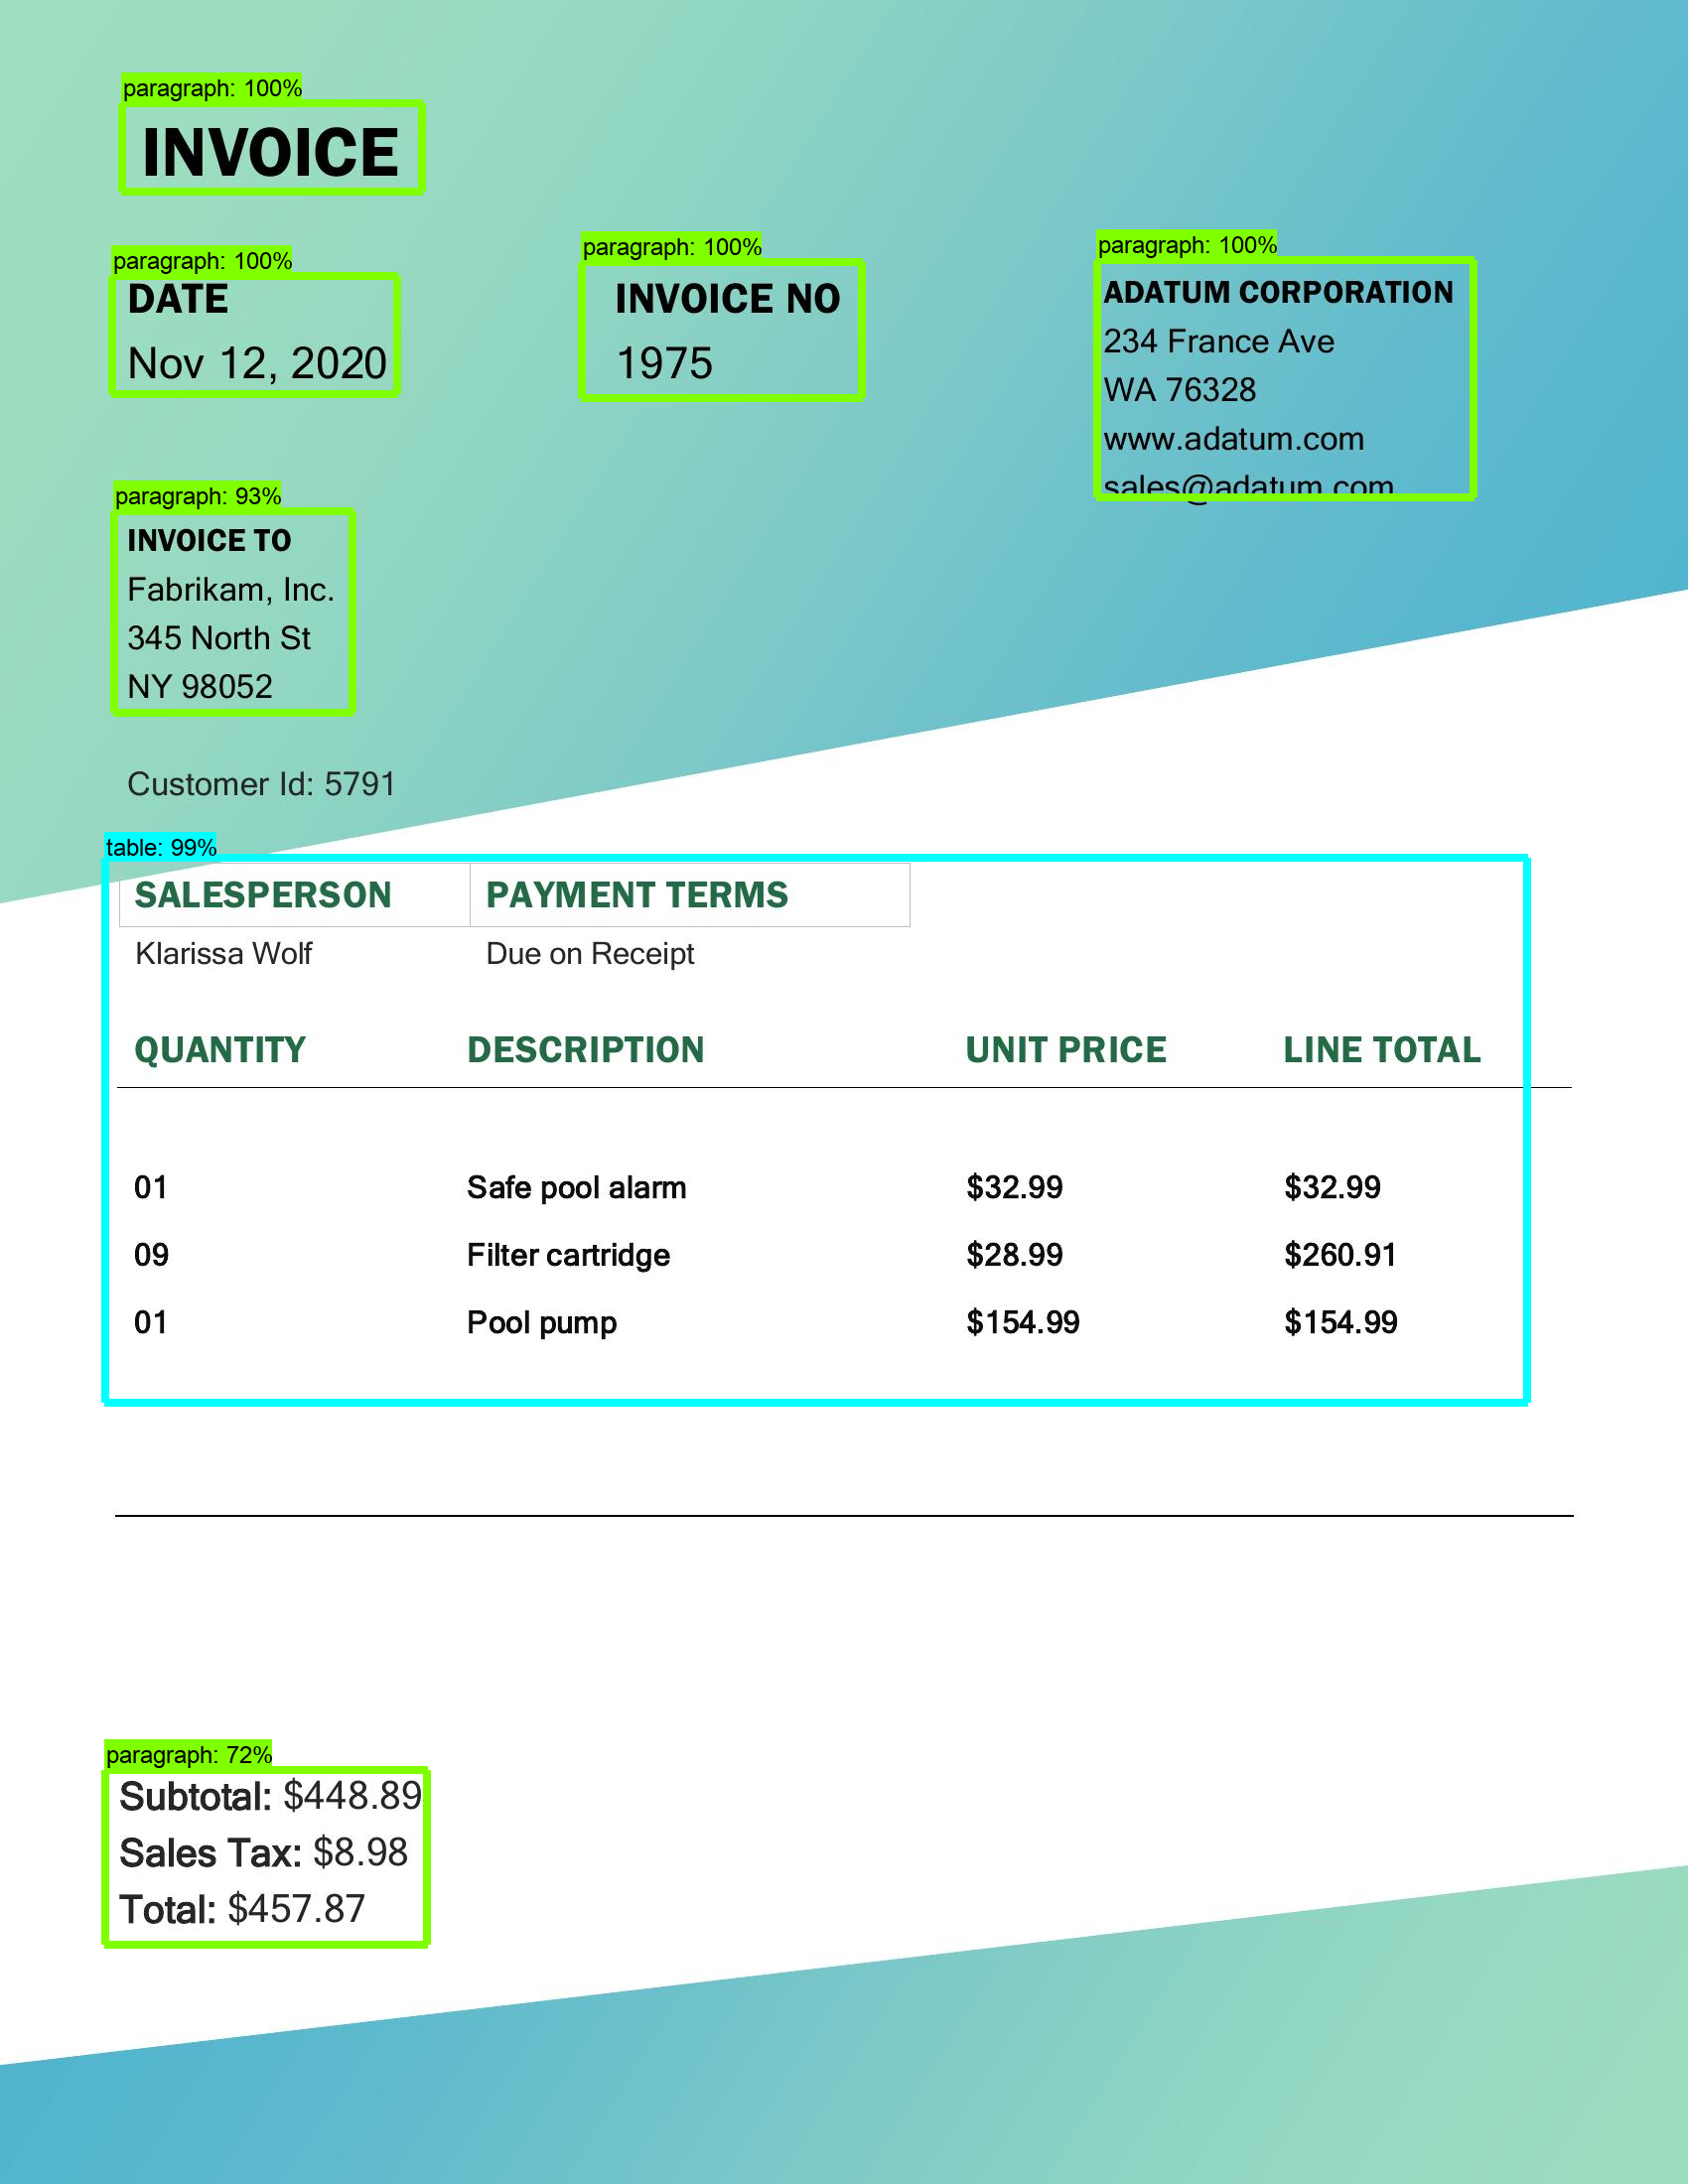

In [11]:
from inferenceutils import *

image_test = 'adatum_test.jpg'
image_np = load_image_into_numpy_array('dataset/'+image_test)
output_dict = run_inference_for_single_image(model, image_np)
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8)
display(Image.fromarray(image_np))

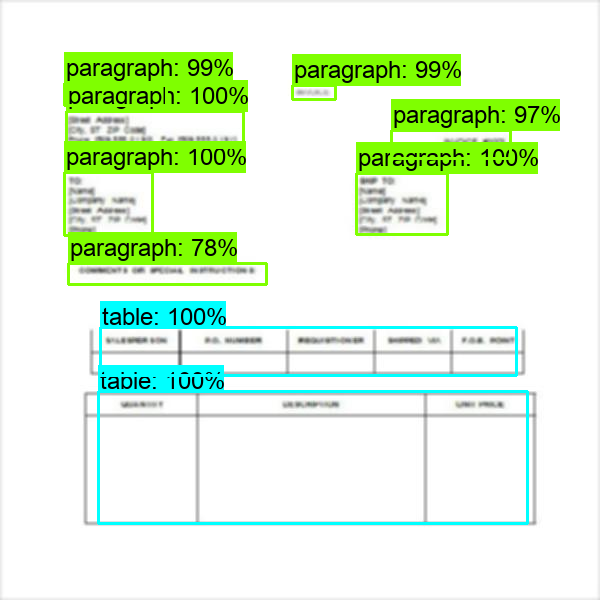

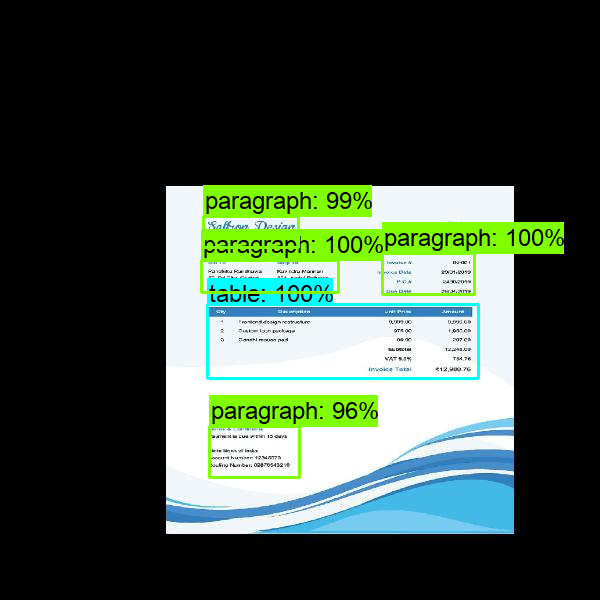

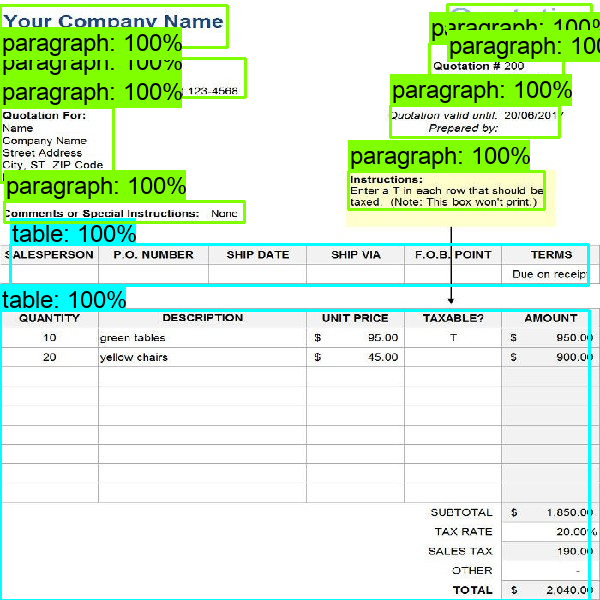

In [10]:
for image_name in images:
    image_np = load_image_into_numpy_array('dataset/images/test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    display(Image.fromarray(image_np))

# 12) Export the predicted coordinates as CSV file

In [12]:
# for single image, use this code

import pandas as pd
rows = []

final_dataframe = pd.DataFrame(columns=['Image','Score','Class','Ymin','Xmin','Ymax','Xmax'])
image_np = load_image_into_numpy_array('dataset/'+image_test)
output_dict = run_inference_for_single_image(model, image_np)
# store boxes in dataframe!
cut_off_scores = len(list(filter(lambda x: x >= 0.1, output_dict['detection_scores'])))
for j in range(cut_off_scores):
    name = image_test
    scores = output_dict['detection_scores'][j]
    classes = output_dict['detection_classes'][j]
    for i in range(1,len(category_index)+1):
        if output_dict['detection_classes'][j] == category_index[i]['id']:
            classes = category_index[i]['name']
    ymin = output_dict['detection_boxes'][j][0]
    xmin = output_dict['detection_boxes'][j][1]
    ymax = output_dict['detection_boxes'][j][2]
    xmax = output_dict['detection_boxes'][j][3]
    row = list([name, scores, classes, ymin, xmin, ymax, xmax])
    rows.append(row)

final_df = pd.DataFrame(rows, columns = ['Image', 'Scores', 'Classes', 'ymin', 'xmin', 'ymax', 'xmax'])
final_df.to_csv('dataset/predicted_coordinates.csv', index = False)
final_df

,Image,Scores,Classes,ymin,xmin,ymax,xmax
0,adatum_test.jpg,0.999304,paragraph,0.119357,0.649645,0.227664,0.873510
1,adatum_test.jpg,0.998968,paragraph,0.126476,0.065927,0.180113,0.235527
2,adatum_test.jpg,0.996288,paragraph,0.047686,0.071773,0.087611,0.250307
3,adatum_test.jpg,0.995508,paragraph,0.120270,0.344528,0.181864,0.511095
4,adatum_test.jpg,0.988247,table,0.393021,0.062114,0.642162,0.905221
5,adatum_test.jpg,0.926152,paragraph,0.234367,0.067634,0.325942,0.208920
6,adatum_test.jpg,0.723910,paragraph,0.810895,0.062157,0.890086,0.253207


In [13]:
from tqdm import tqdm

rows = []

final_dataframe = pd.DataFrame(columns=['Image','Score','Class','Ymin','Xmin','Ymax','Xmax'])
for image_name in tqdm(images):
  
    image_np = load_image_into_numpy_array('dataset/images/test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)

    # store boxes in dataframe!
    cut_off_scores = len(list(filter(lambda x: x >= 0.1, output_dict['detection_scores'])))

    for j in range(cut_off_scores):
        name = image_name
        scores = output_dict['detection_scores'][j]
        classes = output_dict['detection_classes'][j]
        for i in range(1,len(category_index)+1):
            if output_dict['detection_classes'][j] == category_index[i]['id']:
                classes = category_index[i]['name']
        ymin = output_dict['detection_boxes'][j][0]
        xmin = output_dict['detection_boxes'][j][1]
        ymax = output_dict['detection_boxes'][j][2]
        xmax = output_dict['detection_boxes'][j][3]

        row = list([name, scores, classes, ymin, xmin, ymax, xmax])
        rows.append(row)

final_df = pd.DataFrame(rows, columns = ['Image', 'Scores', 'Classes', 'ymin', 'xmin', 'ymax', 'xmax'])
final_df.to_csv('dataset/predicted_coordinates.csv', index = False)
final_df

100%|██████████| 3/3 [00:19<00:00,  6.61s/it]


,Image,Scores,Classes,ymin,xmin,ymax,xmax
0,Invoice_115_gaussianblur.jpg,0.999847,table,0.653252,0.163618,0.872630,0.878403
1,Invoice_115_gaussianblur.jpg,0.999579,paragraph,0.288226,0.108159,0.392813,0.254989
2,Invoice_115_gaussianblur.jpg,0.999552,table,0.545246,0.167760,0.625497,0.860435
3,Invoice_115_gaussianblur.jpg,0.999477,paragraph,0.288966,0.594380,0.390123,0.746251
4,Invoice_115_gaussianblur.jpg,0.997813,paragraph,0.185420,0.110981,0.245557,0.405471
5,Invoice_115_gaussianblur.jpg,0.990516,paragraph,0.138954,0.106996,0.175171,0.276716
6,Invoice_115_gaussianblur.jpg,0.989128,paragraph,0.141829,0.487864,0.165714,0.559447
7,Invoice_115_gaussianblur.jpg,0.971110,paragraph,0.216730,0.652277,0.263637,0.850689
8,Invoice_115_gaussianblur.jpg,0.780441,paragraph,0.438758,0.114934,0.474709,0.444950
9,Invoice_146_affine_translation.jpg,0.998692,table,0.506684,0.345081,0.631524,0.798128
